In [1]:
from tensorflow import keras
import tensorflow_addons as tfa
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np

import tensorflow_datasets as tfds

tfds.disable_progress_bar()

2025-11-17 17:00:42.029222: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-17 17:00:42.029248: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-17 17:00:42.030288: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-17 17:00:42.035493: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-17 17:00:42.512707: W tensorflow/compiler/tf2

In [2]:
AUTO = tf.data.AUTOTUNE  # Used to dynamically adjust parallelism.
BATCH_SIZE = 64

# Comes from Table 4 and "Training setup" section.
TEMPERATURE = 10  # Used to soften the logits before they go to softmax.
INIT_LR = 0.003  # Initial learning rate that will be decayed over the training period.
WEIGHT_DECAY = 0.001  # Used for regularization.
CLIP_THRESHOLD = 1.0  # Used for clipping the gradients by L2-norm.

# We will first resize the training images to a bigger size and then we will take
# random crops of a lower size.
BIGGER = 160
RESIZE = 128

In [3]:
train_ds, validation_ds, test_ds = tfds.load(
    "oxford_flowers102", split=["train", "validation", "test"], as_supervised=True
)
print(f"Number of training examples: {train_ds.cardinality()}.")
print(
    f"Number of validation examples: {validation_ds.cardinality()}."
)
print(f"Number of test examples: {test_ds.cardinality()}.")

Number of training examples: 1020.
Number of validation examples: 1020.
Number of test examples: 6149.


2025-11-17 17:00:44.100762: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-11-17 17:00:44.135495: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-11-17 17:00:44.146200: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [4]:
import os

os.environ["KAGGLE_USERNAME"] = "attilamacsotai" # TODO: enter your Kaggle user name here
os.environ["KAGGLE_KEY"] = "ca9f42d1b11d5e4bac050cef692fc2ef" # TODO: enter your Kaggle key here

In [5]:
#!kaggle datasets download -d spsayakpaul/bitresnet101x3flowers102

In [6]:
#!unzip -qq bitresnet101x3flowers102.zip

In [7]:
# Since the teacher model is not going to be trained further we make
# it non-trainable.
teacher_model = keras.models.load_model(
    "T-r101x3-128"
)
teacher_model.trainable = False
teacher_model.summary()

2025-11-17 17:00:53.209346: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 're_lu_99/PartitionedCall' has 1 outputs but the _output_shapes attribute specifies shapes for 2 outputs. Output shapes may be inaccurate.
2025-11-17 17:00:53.209380: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'global_average_pooling2d/PartitionedCall' has 1 outputs but the _output_shapes attribute specifies shapes for 4 outputs. Output shapes may be inaccurate.


Model: "my_bi_t_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             multiple                  626790    
                                                                 
 keras_layer_1 (KerasLayer)  multiple                  381789888 
                                                                 
Total params: 382416678 (1.42 GB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 382416678 (1.42 GB)
_________________________________________________________________


In [8]:
def mixup(images, labels):
    alpha = tf.random.uniform([], 0, 1)
    mixedup_images = alpha * images + (1 - alpha) * tf.reverse(images, axis=[0])
    # The labels do not matter here since they are NOT used during
    # training.
    return mixedup_images, labels


def preprocess_image(image, label, train=True):
    image = tf.cast(image, tf.float32) / 255.0

    if train:
        image = tf.image.resize(image, (BIGGER, BIGGER))
        image = tf.image.random_crop(image, (RESIZE, RESIZE, 3))
        image = tf.image.random_flip_left_right(image)
    else:
        # Central fraction amount is from here:
        # https://git.io/J8Kda.
        image = tf.image.central_crop(image, central_fraction=0.875)
        image = tf.image.resize(image, (RESIZE, RESIZE))

    return image, label


def prepare_dataset(dataset, train=True, batch_size=BATCH_SIZE):
    if train:
        dataset = dataset.map(preprocess_image, num_parallel_calls=AUTO)
        dataset = dataset.shuffle(BATCH_SIZE * 10)
    else:
        dataset = dataset.map(
            lambda x, y: (preprocess_image(x, y, train)), num_parallel_calls=AUTO
        )
    dataset = dataset.batch(batch_size)

    if train:
        dataset = dataset.map(mixup, num_parallel_calls=AUTO)

    dataset = dataset.prefetch(AUTO)
    return dataset

In [9]:
train_ds = prepare_dataset(train_ds, True)
validation_ds = prepare_dataset(validation_ds, False)
test_ds = prepare_dataset(test_ds, False)

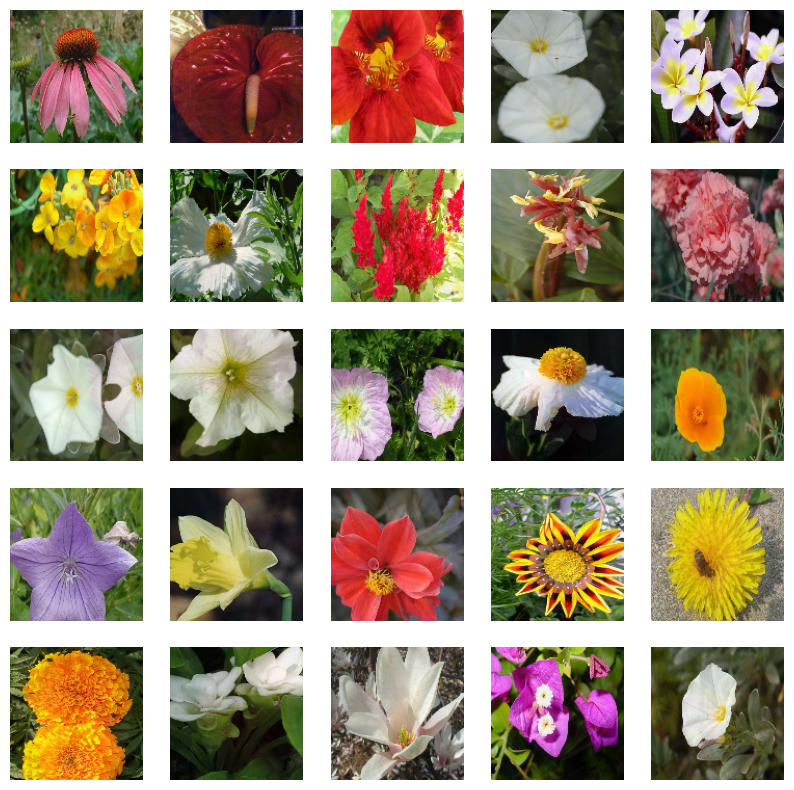

In [10]:
sample_images, _ = next(iter(train_ds))
plt.figure(figsize=(10, 10))
for n in range(25):
    ax = plt.subplot(5, 5, n + 1)
    plt.imshow(sample_images[n].numpy())
    plt.axis("off")
plt.show()

In [11]:
def get_resnetv2():
    resnet_v2 = keras.applications.ResNet50V2(
        weights=None,
        input_shape=(RESIZE, RESIZE, 3),
        classes=102,
        classifier_activation="linear",
    )
    return resnet_v2


get_resnetv2().count_params()

23773798

In [12]:
class Distiller(tf.keras.Model):
    def __init__(self, student, teacher):
        super().__init__()
        self.student = student
        self.teacher = teacher
        self.loss_tracker = keras.metrics.Mean(name="distillation_loss")

    @property
    def metrics(self):
        metrics = super().metrics
        metrics.append(self.loss_tracker)
        return metrics

    def compile(
        self, optimizer, metrics, distillation_loss_fn, temperature=TEMPERATURE,
    ):
        super().compile(optimizer=optimizer, metrics=metrics)
        self.distillation_loss_fn = distillation_loss_fn
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, _ = data

        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute loss
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1),
            )

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(distillation_loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Report progress
        self.loss_tracker.update_state(distillation_loss)
        return {"distillation_loss": self.loss_tracker.result()}

    def test_step(self, data):
        # Unpack data
        x, y = data

        # Forward passes
        teacher_predictions = self.teacher(x, training=False)
        student_predictions = self.student(x, training=False)

        # Calculate the loss
        distillation_loss = self.distillation_loss_fn(
            tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
            tf.nn.softmax(student_predictions / self.temperature, axis=1),
        )

        # Report progress
        self.loss_tracker.update_state(distillation_loss)
        self.compiled_metrics.update_state(y, student_predictions)
        results = {m.name: m.result() for m in self.metrics}
        return results

In [13]:
# Some code is taken from:
# https://www.kaggle.com/ashusma/training-rfcx-tensorflow-tpu-effnet-b2.


class WarmUpCosine(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super().__init__()

        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")

        cos_annealed_lr = tf.cos(
            self.pi
            * (tf.cast(step, tf.float32) - self.warmup_steps)
            / float(self.total_steps - self.warmup_steps)
        )
        learning_rate = 0.5 * self.learning_rate_base * (1 + cos_annealed_lr)

        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )

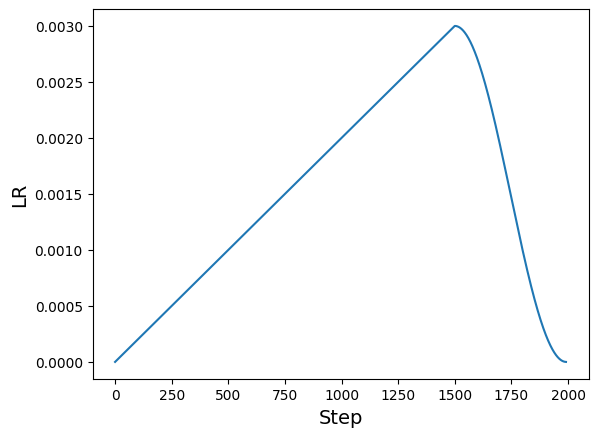

In [14]:
ARTIFICIAL_EPOCHS = 1000
ARTIFICIAL_BATCH_SIZE = 512
DATASET_NUM_TRAIN_EXAMPLES = 1020
TOTAL_STEPS = int(
    DATASET_NUM_TRAIN_EXAMPLES / ARTIFICIAL_BATCH_SIZE * ARTIFICIAL_EPOCHS
)
scheduled_lrs = WarmUpCosine(
    learning_rate_base=INIT_LR,
    total_steps=TOTAL_STEPS,
    warmup_learning_rate=0.0,
    warmup_steps=1500,
)

lrs = [scheduled_lrs(step) for step in range(TOTAL_STEPS)]
plt.plot(lrs)
plt.xlabel("Step", fontsize=14)
plt.ylabel("LR", fontsize=14)
plt.show()

In [15]:
optimizer = tfa.optimizers.AdamW(
    weight_decay=WEIGHT_DECAY, learning_rate=scheduled_lrs, clipnorm=CLIP_THRESHOLD
)

student_model = get_resnetv2()

distiller = Distiller(student=student_model, teacher=teacher_model)
distiller.compile(
    optimizer,
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
    distillation_loss_fn=keras.losses.KLDivergence(),
    temperature=TEMPERATURE,
)

history = distiller.fit(
    train_ds,
    steps_per_epoch=int(np.ceil(DATASET_NUM_TRAIN_EXAMPLES / BATCH_SIZE)),
    validation_data=validation_ds,
    epochs=30,  # This should be at least 1000.
)

student = distiller.student
student_model.compile(metrics=["accuracy"])
_, top1_accuracy = student.evaluate(test_ds)
print(f"Top-1 accuracy on the test set: {round(top1_accuracy * 100, 2)}%")

Epoch 1/30


2025-11-17 17:01:10.666191: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2025-11-17 17:01:15.462148: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.37GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-11-17 17:01:15.554209: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.37GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


15/16 [===========================>..] - ETA: 0s - distillation_loss: 0.0072

2025-11-17 17:01:29.863364: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.78GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-11-17 17:01:29.993129: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.78GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-11-17 17:01:30.570967: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.78GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-11-17 17:01:30.738689: W external/local_tsl/tsl/framework/bfc_

16/16 [==============================] - 43s 2s/step - distillation_loss: 0.0072 - val_sparse_categorical_accuracy: 0.0098 - val_distillation_loss: 0.0061
Epoch 2/30
16/16 [==============================] - 23s 1s/step - distillation_loss: 0.0056 - val_sparse_categorical_accuracy: 0.0137 - val_distillation_loss: 0.0060
Epoch 3/30
16/16 [==============================] - 23s 1s/step - distillation_loss: 0.0052 - val_sparse_categorical_accuracy: 0.0098 - val_distillation_loss: 0.0060
Epoch 4/30
16/16 [==============================] - 24s 2s/step - distillation_loss: 0.0045 - val_sparse_categorical_accuracy: 0.0098 - val_distillation_loss: 0.0059
Epoch 5/30
16/16 [==============================] - 24s 2s/step - distillation_loss: 0.0043 - val_sparse_categorical_accuracy: 0.0098 - val_distillation_loss: 0.0060
Epoch 6/30
16/16 [==============================] - 24s 2s/step - distillation_loss: 0.0040 - val_sparse_categorical_accuracy: 0.0098 - val_distillation_loss: 0.0061
Epoch 7/30
16/1

In [16]:
# Download the pre-trained weights.
!wget https://git.io/JBO3Y -O S-r50x1-128-1000.tar.gz
!tar xf S-r50x1-128-1000.tar.gz

--2025-11-17 17:13:40--  https://git.io/JBO3Y
Resolving git.io (git.io)... 140.82.112.21
Connecting to git.io (git.io)|140.82.112.21|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/sayakpaul/FunMatch-Distillation/releases/download/v3.0.0/S-r50x1-128-1000.tar.gz [following]
--2025-11-17 17:13:41--  https://github.com/sayakpaul/FunMatch-Distillation/releases/download/v3.0.0/S-r50x1-128-1000.tar.gz
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/389064229/9443bddf-9167-44fd-80aa-4304b3d8a9c6?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-11-17T17%3A08%3A15Z&rscd=attachment%3B+filename%3DS-r50x1-128-1000.tar.gz&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&s

In [17]:
pretrained_student = keras.models.load_model("S-r50x1-128-1000")
pretrained_student.summary()

Model: "resnet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 root_block (Sequential)     (None, 32, 32, 64)        9408      
                                                                 
 block1 (Sequential)         (None, 32, 32, 256)       214912    
                                                                 
 block2 (Sequential)         (None, 16, 16, 512)       1218048   
                                                                 
 block3 (Sequential)         (None, 8, 8, 1024)        7095296   
                                                                 
 block4 (Sequential)         (None, 4, 4, 2048)        14958592  
                                                                 
 group_norm (GroupNormaliza  multiple                  4096      
 tion)                                                           
                                                            

In [18]:
_, top1_accuracy = pretrained_student.evaluate(test_ds)
print(f"Top-1 accuracy on the test set: {round(top1_accuracy * 100, 2)}%")

97/97 [==============================] - 8s 76ms/step - loss: 0.0000e+00 - accuracy: 0.8102
Top-1 accuracy on the test set: 81.02%
